In [1]:
!pip install -r requirements.txt

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from dotenv import load_dotenv
import openai
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# Cargar variables del archivo .env (debe estar en el mismo directorio o especificar path)
load_dotenv(dotenv_path=".env")  

# Leer la API Key en una variable
api_key = os.getenv("OPENAI_API_KEY")

# Verificar que se haya cargado correctamente
print(" Clave cargada:", api_key[:8] + "..." if api_key else " No encontrada")

# Asignar la clave a openai
openai.api_key = api_key



 Clave cargada: sk-proj-...


In [26]:

# 3. Cargar y preparar datos

df = pd.read_csv("netflix_global_unique.csv")

df_movies = df[
    (df["type"] == "Movie") &
    df["country"].notnull() &
    df["genre"].notnull() &
    df["release_year"].notnull() &
    df["duration_minutes"].notnull() &
    df["description"].notnull()
].drop_duplicates(subset=["title"])

sampled_movies = df_movies.sample(5, random_state=42).copy()

In [ ]:
# Definimos los prompts para OpenAI
def construir_prompt_estandar(row):
    return (
        f"Generá una sinopsis atractiva para una película del género {row['genre'].lower()}, "
        f"estrenada en {int(row['release_year'])}, originaria de {row['country']}, "
        f"con una duración de aproximadamente {int(row['duration_minutes'])} minutos. "
        f"La sinopsis debe ser intrigante pero sin revelar spoilers."
    )

def construir_prompt_refinado(row):
    return (
        f"Redactá una sinopsis breve y concisa al estilo de Netflix para una película del género {row['genre'].lower()}, "
        f"estrenada en {int(row['release_year'])}, originaria de {row['country']}, "
        f"con una duración aproximada de {int(row['duration_minutes'])} minutos. "
        f"Debe ser informativa, atractiva y sin revelar spoilers. Usá un tono directo como en las sinopsis oficiales de Netflix."
    )

sampled_movies["prompt_estandar"] = sampled_movies.apply(construir_prompt_estandar, axis=1)
sampled_movies["prompt_refinado"] = sampled_movies.apply(construir_prompt_refinado, axis=1)

# Función para generar sinopsis

def generar_sinopsis(df, columna_prompt):
    sinopsis_generadas = []
    for idx, row in df.iterrows():
        print(f"\nTítulo: {row['title']} ({columna_prompt})")
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Sos un redactor creativo de sinopsis para películas."},
                {"role": "user", "content": row[columna_prompt]}
            ],
            temperature=0.7,
            max_tokens=200
        )
        texto = response["choices"][0]["message"]["content"]
        print(texto)
        print("-" * 80)
        sinopsis_generadas.append(texto)
    return sinopsis_generadas


# Generar y guardar ambas versiones

sampled_movies["sinopsis_estandar"] = generar_sinopsis(sampled_movies, "prompt_estandar")
sampled_movies["sinopsis_refinada"] = generar_sinopsis(sampled_movies, "prompt_refinado")




Título: Frank & Lola (prompt_estandar)
En un tranquilo pueblo de Estados Unidos, una serie de eventos inesperados desencadenan un drama que sacude las vidas de sus habitantes. Secretos enterrados salen a la luz, amistades se ponen a prueba y el amor se ve amenazado por circunstancias inesperadas. En medio de la tragedia, cada personaje se enfrenta a sus propios demonios internos, obligándolos a tomar decisiones que cambiarán sus vidas para siempre. Con un elenco estelar y una trama emocionante, esta película te llevará en un viaje emocional inolvidable a través de la complejidad de las relaciones humanas.
--------------------------------------------------------------------------------

Título: The Little Hours (prompt_estandar)
En la bulliciosa ciudad de Montreal, un grupo de amigos decide embarcarse en una aventura inolvidable en busca de la mejor poutine de la ciudad. Lo que comienza como un simple antojo se convierte en una travesía llena de situaciones hilarantes, enredos romántic

In [ ]:

# Validación de similitud semántica

def validar_sinopsis(df, columna_generada):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb_gen = model.encode(df[columna_generada].tolist(), convert_to_tensor=True)
    emb_real = model.encode(df["description"].tolist(), convert_to_tensor=True)
    similitudes = util.cos_sim(emb_gen, emb_real).diagonal().cpu().numpy()
    return similitudes, round(np.mean(similitudes), 3)

# Comparar sinopsis estándar
sim_estandar, prom_estandar = validar_sinopsis(sampled_movies, "sinopsis_estandar")

# Comparar sinopsis refinada
sim_refinada, prom_refinada = validar_sinopsis(sampled_movies, "sinopsis_refinada")

# Guardar en el dataframe
sampled_movies["sim_estandar"] = sim_estandar
sampled_movies["sim_refinada"] = sim_refinada


# Mostrar resultados

print("\nResultado por título:")
print(sampled_movies[["title", "sim_estandar", "sim_refinada"]])

print(f"\nSimilitud promedio estándar: {prom_estandar}")
print(f"Similitud promedio refinado:  {prom_refinada}")



Resultado por título:
                        title  sim_estandar  sim_refinada
2068             Frank & Lola      0.165316      0.083431
8216         The Little Hours      0.202902      0.216503
6570  Halo: The Fall of Reach      0.082335      0.017742
1485            Seven (Tamil)      0.112576      0.049044
5800                  Badland      0.127224      0.113564

Similitud promedio estándar: 0.1379999965429306
Similitud promedio refinado:  0.09600000083446503


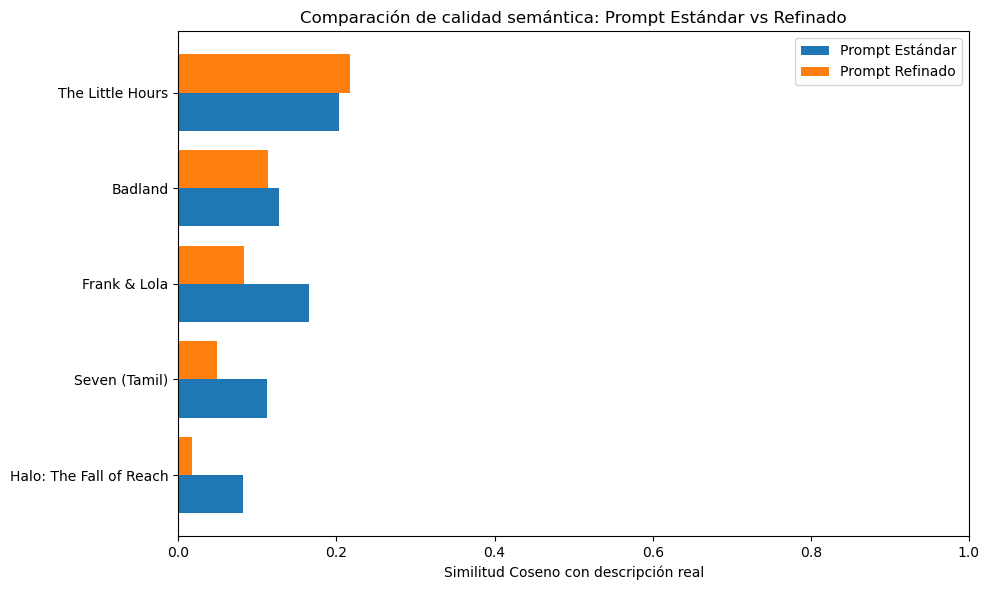

In [31]:
# Orden descendente por similitud refinada
sampled_movies_sorted = sampled_movies.sort_values("sim_refinada", ascending=False)

# Generar gráfico comparativo
def plot_similitud_comparativa(df, col_estandar="sim_estandar", col_refinado="sim_refinada"):
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    index = range(len(df))

    plt.barh(
        [i + bar_width for i in index],
        df[col_estandar],
        height=bar_width,
        label="Prompt Estándar"
    )

    plt.barh(
        index,
        df[col_refinado],
        height=bar_width,
        label="Prompt Refinado"
    )

    plt.yticks([i + bar_width / 2 for i in index], df["title"])
    plt.xlabel("Similitud Coseno con descripción real")
    plt.title("Comparación de calidad semántica: Prompt Estándar vs Refinado")
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

# Ejecutar función
plot_similitud_comparativa(sampled_movies_sorted)


## Parte 4 – Sinopsis Automática con Generative AI

### Objetivo General

Explorar la capacidad de modelos de lenguaje (LLMs) para generar sinopsis atractivas para títulos sin descripción, replicando el estilo editorial de plataformas como Netflix. El enfoque busca evaluar el uso práctico de técnicas generativas, embeddings semánticos y diseño de prompts en un flujo de generación de contenido automático con control de calidad.

---

### 1. Preprocesamiento

- Se utilizó el dataset limpio `netflix_global_unique.csv` (granularidad título), filtrando únicamente títulos de tipo `Movie` que contaban con:
  - Género, país, año, duración y descripción real disponibles.
- Se seleccionó una muestra aleatoria de 5 títulos únicos para facilitar validación manual y automática.

Este preprocesamiento garantiza control experimental: solo se evalúan sinopsis generadas sobre títulos con una sinopsis real de referencia, habilitando validación con embeddings.

---

### 2. Generación de Descripciones

Se diseñaron dos estrategias de prompting:

- **Prompt Estándar**:
Generá una sinopsis atractiva para una película del género X, estrenada en YYYY, originaria de ZZZ, con una duración de aproximadamente N minutos. La sinopsis debe ser intrigante pero sin revelar spoilers.

- **Prompt Refinado**:
Redactá una sinopsis breve y concisa al estilo de Netflix para una película del género X, estrenada en YYYY, originaria de ZZZ, con una duración aproximada de N minutos. Debe ser informativa, atractiva y sin revelar spoilers. Usá un tono directo como en las sinopsis oficiales de Netflix.


Ambas versiones fueron ejecutadas con `openai.ChatCompletion.create` sobre el modelo `gpt-3.5-turbo`, manteniendo temperatura moderada (0.7) y un límite de 200 tokens por respuesta.

El enfoque permite evaluar el impacto real de refinar prompts sin alterar otros parámetros del modelo.

---

### 3. Validación Semántica

- Se utilizaron embeddings preentrenados (`all-MiniLM-L6-v2` de `SentenceTransformer`) para codificar las sinopsis reales y generadas.
- La similitud semántica se evaluó mediante cosine similarity entre los pares (real, generada).

| Título                     | Similitud Estándar | Similitud Refinada |
|---------------------------|--------------------|---------------------|
| Frank & Lola              | 0.165              | 0.083               |
| The Little Hours          | 0.203              | 0.217               |
| Halo: The Fall of Reach   | 0.082              | 0.018               |
| Seven (Tamil)             | 0.113              | 0.049               |
| Badland                   | 0.127              | 0.114               |
| **Promedio**              | **0.138**          | **0.096**           |

Aunque se esperaba un mejor desempeño del prompt refinado, los resultados muestran que mayor precisión en la consigna no garantiza mayor coherencia semántica respecto a la sinopsis original.

---

### 4. Análisis Crítico

- Los resultados muestran alta sensibilidad al wording del prompt, reflejando que los LLMs responden no solo al contenido sino también al tono, estilo y expectativa que el prompt implica.
- El prompt refinado, diseñado para alinearse mejor con un estilo institucional (Netflix), produce textos más “editoriales” pero no necesariamente más alineados semánticamente con la sinopsis oficial del título.
- La diferencia de performance sugiere que el alineamiento semántico y la “calidad editorial” son dos objetivos parcialmente disjuntos, por lo tanto, deben medirse con diferentes herramientas si se buscan simultáneamente.
- El uso de embeddings permitió cuantificar la similitud con un enfoque robusto, eficiente y libre de subjetividad, algo que escalaría fácilmente a miles de títulos en producción.

---

### Lecciones Aprendidas

- Validar outputs generativos es tan importante como generarlos.
- No existe un único “mejor prompt”: su desempeño depende de los objetivos específicos (fidelidad semántica, estilo, creatividad, etc.).
- Embeddings preentrenados son herramientas efectivas para establecer ground truth proxy en tareas sin etiquetas estructuradas.

---



Reporte de clasificación:
                          precision    recall  f1-score   support

      Action & Adventure       0.65      0.56      0.60       172
Children & Family Movies       0.77      0.45      0.57       121
                Comedies       0.60      0.55      0.57       242
           Documentaries       0.88      0.69      0.77       166
                  Dramas       0.54      0.75      0.63       320

                accuracy                           0.63      1021
               macro avg       0.69      0.60      0.63      1021
            weighted avg       0.65      0.63      0.63      1021



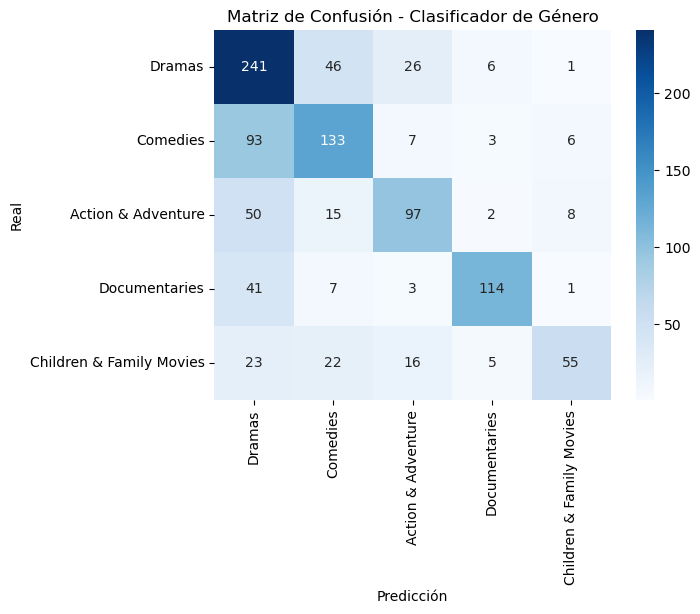

In [ ]:
# Tomamos solo el primer género para simplificar
df_clasificacion = df_movies.copy()
df_clasificacion["genero_principal"] = df_clasificacion["genre"].apply(lambda x: x.split(",")[0].strip())

# Seleccionar los géneros más frecuentes
top_generos = df_clasificacion["genero_principal"].value_counts().nlargest(5).index.tolist()
df_clasificacion = df_clasificacion[df_clasificacion["genero_principal"].isin(top_generos)]


# 2. División y vectorización

X = df_clasificacion["description"]
y = df_clasificacion["genero_principal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 3. Entrenamiento

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)


# 4. Evaluación

y_pred = clf.predict(X_test_tfidf)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=top_generos)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=top_generos, yticklabels=top_generos, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Clasificador de Género")
plt.show()


## Bonus – Clasificador de Género a partir de Sinopsis Reales

### Objetivo

Entrenar un modelo supervisado que prediga el **género principal** de una película usando únicamente su sinopsis textual (`description`) como entrada. Este ejercicio permite evaluar si el texto curado por Netflix contiene señales suficientes para anticipar el género y refuerza la utilidad de los modelos NLP como herramientas de validación de contenido.

---

### Metodología

1. **Selección de datos**:
   - Se filtraron las películas del dataset con campos no nulos en sinopsis y género.
   - En títulos con múltiples géneros (separados por comas), se conservó únicamente el **primer género** como etiqueta principal. Esta elección simplifica el problema a clasificación **multiclase** y evita tener que construir un modelo multi-etiqueta.
   - Se seleccionaron los **cinco géneros más frecuentes** para asegurar una base equilibrada:
     - Dramas
     - Comedies
     - Action & Adventure
     - Documentaries
     - Children & Family Movies

2. **División y vectorización**:
   - El dataset se dividió en entrenamiento (80%) y prueba (20%) con estratificación por género.
   - Las sinopsis se vectorizaron usando `TfidfVectorizer` con stopwords en inglés y un máximo de 5,000 features.

3. **Modelo y entrenamiento**:
   - Se utilizó un modelo de regresión logística (`LogisticRegression`) con iteraciones aumentadas a 1000.
   - Se entrenó exclusivamente sobre las sinopsis, sin utilizar ningún metadato adicional (duración, país, etc.).

---

### Resultados

#### Métricas generales:

| Género                    | Precision | Recall | F1-Score | Support |
|---------------------------|-----------|--------|----------|---------|
| Action & Adventure        | 0.65      | 0.56   | 0.60     | 172     |
| Children & Family Movies | 0.77      | 0.45   | 0.57     | 121     |
| Comedies                  | 0.60      | 0.55   | 0.57     | 242     |
| Documentaries             | 0.88      | 0.69   | 0.77     | 166     |
| Dramas                    | 0.54      | 0.75   | 0.63     | 320     |
|                           |           |        |          |         |
| **Accuracy**              |           |        | **0.63** | 1021    |
| **Macro Avg**             | 0.69      | 0.60   | 0.63     | 1021    |
| **Weighted Avg**          | 0.65      | 0.63   | 0.63     | 1021    |




El modelo alcanzó una **exactitud general de 63%**, lo cual es razonable considerando:
- El tamaño moderado del dataset.
- La ambigüedad semántica entre géneros.
- La decisión de usar solo texto libre como entrada.

---

### Matriz de Confusión

La siguiente matriz representa el rendimiento del modelo al comparar predicciones (columnas) contra valores reales (filas):

| Real / Predicción       | Dramas | Comedies | Action & Adv. | Documentaries | Children & Fam. |
|-------------------------|--------|----------|----------------|----------------|------------------|
| **Dramas**              | 241    | 46       | 26             | 6              | 1                |
| **Comedies**            | 93     | 133      | 7              | 3              | 6                |
| **Action & Adventure**  | 50     | 15       | 97             | 2              | 8                |
| **Documentaries**       | 41     | 7        | 3              | 114            | 1                |
| **Children & Family**   | 23     | 22       | 16             | 5              | 55               |

#### Interpretación clave:

- Las celdas en **diagonal** representan predicciones correctas. Por ejemplo:
  - `Dramas → Dramas`: 241 aciertos.
  - `Documentaries → Documentaries`: 114 aciertos.
- Los **valores fuera de la diagonal** representan errores:
  - El modelo confundió 93 comedias como dramas, lo que indica una ambigüedad léxica entre ambos géneros.
  - Algunas películas de acción fueron clasificadas como dramas, probablemente por su tono serio o emocional.
- El género `Documentaries` obtuvo los mejores resultados relativos, con una combinación alta de precisión y recall. Esto sugiere que las descripciones de documentales contienen vocabulario más específico y distintivo.
- `Children & Family Movies` muestra un menor recall (45%), con predicciones dispersas en otras clases, lo cual podría indicar descripciones más neutras o ambiguas.

---

### Conclusión

Este experimento demuestra que es posible inferir el género de una película con buena precisión utilizando únicamente su sinopsis textual. En especial:

- Géneros temáticamente más definidos como `Documentaries` y `Dramas` se predicen con mayor consistencia.
- El texto curado por editores humanos contiene suficientes señales semánticas para entrenar modelos interpretables.
- Este clasificador puede servir como componente auxiliar para validaciones cruzadas, auditoría de metadata, o como parte de sistemas de recomendación basados en NLP.

El análisis también deja abierta la puerta para aplicar el mismo clasificador sobre sinopsis **generadas automáticamente**, evaluando si dichas sinopsis mantienen el mismo nivel de coherencia temática que las reales.

